In [1]:
import sys
sys.path.append('/cellar/users/zkoch/methylation_and_mutation/source_files')
%load_ext autoreload
%aimport compute_comethylation, utils
%autoreload 1
import get_data, analysis, utils, plotting, compute_comethylation, methyl_mut_burden, somatic_mut_clock, mutation_features, methylation_pred

/cellar/users/zkoch/miniconda3/envs/tf_env/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/cellar/users/zkoch/miniconda3/envs/tf_env/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
 

In [2]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
import pickle
import dask.dataframe as dd
from scipy.stats import spearmanr
from rich.progress import track
import statsmodels.formula.api as smf
import matplotlib.ticker as ticker
from scipy.stats import spearmanr, pearsonr, mannwhitneyu
from scipy import stats
import dask
import sklearn
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from pyfaidx import Fasta


%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-deep")
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


In [3]:
fig_out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures"

# Read in ICGC Data

In [4]:
# qnorm 
icgc_mut_w_age_df, illumina_cpg_locs_df, icgc_methyl_age_df_t, icgc_matrix_qtl_dir, icgc_covariate_fn = get_data.read_icgc_data()

reading in data
Got mutations and metadata, reading methylation
Got methylation, transposing
Done


In [5]:
analyze_comethylation = compute_comethylation.analyzeComethylation()
# distance
paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_comethyl_output/distance_based_100kb/all_metrics*")
c_paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_comethyl_output/distance_based_100kb/comparison_sites*")
m_paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_comethyl_output/distance_based_100kb/mean_metrics*")

In [7]:
# all metrics
"""icgc_dist_all_metrics_dfs = []
for path in paths:
    # read in metrics sites from dask paruet
    one_metrics_dd = dd.read_parquet(path)
    one_metrics_df = one_metrics_dd.compute()
    # subset to only mutated sites
    one_metrics_df = one_metrics_df.loc[one_metrics_df["mutated_sample"] == True]
    icgc_dist_all_metrics_dfs.append(one_metrics_df)
icgc_dist_all_metrics_df = pd.concat(icgc_dist_all_metrics_dfs)
icgc_dist_all_metrics_df.reset_index(inplace=True, drop=True)"""

# write to one parquet file
#icgc_dist_all_metrics_df.to_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_comethyl_output/distance_based_100kb/dist_all_metrics_no_matchedSample.parquet')
icgc_dist_all_metrics_df = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_comethyl_output/distance_based_100kb/dist_all_metrics_no_matchedSample.parquet')

In [32]:
# mean metrics
icgc_dist_mean_metrics_df_l = []
for path in m_paths:
    # read in metrics sites from dask paruet
    one_metrics_df = pd.read_parquet(path)
    icgc_dist_mean_metrics_df_l.append(one_metrics_df)
icgc_dist_mean_metrics_df = pd.concat(icgc_dist_mean_metrics_df_l)

In [6]:
#icgc_dist_mean_metrics_w_annot_df = analyze_comethylation.add_mutation_info_to_mean_metrics_df(icgc_dist_mean_metrics_df, distance = 10000, consortium = 'ICGC')
#icgc_dist_mean_metrics_w_annot_df.to_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_comethyl_output/distance_based_100kb/dist_mean_metrics10kDist.parquet')icgc_dist_mean_metrics_w_annot_df
icgc_dist_mean_metrics_w_annot_df = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_comethyl_output/distance_based_100kb/dist_mean_metrics10kDist.parquet')
icgc_dist_mean_metrics_w_annot_df.drop_duplicates(subset=['mut_event'], inplace=True)

In [9]:
# select only background events corresponding to mutated sites
selected_mut_events = icgc_dist_mean_metrics_w_annot_df.query("mutated_sample == True and is_background == False and DNA_VAF >=.9")['mut_event'].unique()
icgc_dist_mean_metrics_w_annot_df_subset = icgc_dist_mean_metrics_w_annot_df.loc[
    (icgc_dist_mean_metrics_w_annot_df['index_event'].isin(selected_mut_events) | (icgc_dist_mean_metrics_w_annot_df['index_event'] == 'self') & (icgc_dist_mean_metrics_w_annot_df['is_background'] == False))
]
icgc_dist_mean_metrics_w_annot_df_subset_vaf = icgc_dist_mean_metrics_w_annot_df.query("(is_background == False and mutated_sample == True and DNA_VAF >= .8) or is_background == True")
icgc_dist_mean_metrics_w_annot_df_subset_vaf.query("is_background == False and mutated_sample == True and distance == 10000")['mut_event'].nunique()

2599

In [7]:
icgc_dist_mean_metrics_w_annot_df.query("is_background == False and mutated_sample == True and distance == 10000")['mut_event'].nunique()

3880

In [9]:
icgc_dist_mean_metrics_w_annot_df.query("is_background == True and mutated_sample == True")['mut_event'].nunique()

623083

In [10]:
icgc_dist_mean_metrics_w_annot_df.query("is_background == True and mutated_sample == True")['mut_event'].nunique() / icgc_dist_mean_metrics_w_annot_df.query("is_background == False and mutated_sample == True")['mut_event'].nunique()

160.58840206185567

In [ ]:
# comparison sites
icgc_dist_all_comparison_site_dfs = []
for path in c_paths:
    # read in metrics sites from dask paruet
    one_comp_dd = dd.read_parquet(path)
    one_comp_df = one_comp_dd.compute()
    icgc_dist_all_comparison_site_dfs.append(one_comp_df)
icgc_dist_all_comparison_site_df = pd.concat(icgc_dist_all_comparison_site_dfs)
icgc_dist_all_comparison_site_df.reset_index(inplace=True, drop=True)

# Read TCGA Data

In [4]:
# qnorm data
all_mut_w_age_df, illumina_cpg_locs_df, all_methyl_age_df_t, matrix_qtl_dir, covariate_fn = get_data.read_tcga_data()

reading in data
Got mutations and metadata, reading methylation
Converting Dask df to pandas df, takes ~10min
Got methylation, transposing
Done


In [4]:
analyze_comethylation = compute_comethylation.analyzeComethylation()
paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/032423_comethyl_output/distance_based_100kbMax/all_metrics*")
c_paths = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/032423_comethyl_output/distance_based_100kbMax/comparison_sites*")

In [19]:
tcga_dist_all_metrics_df = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/032423_comethyl_output/distance_based_100kbMax/dist_all_metrics_no_matchedSample.parquet')

In [95]:
tcga_dist_mean_metrics_w_annot_df = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/032423_comethyl_output/distance_based_100kbMax/dist_mean_metrics_w_mut_info_df_10kb.parquet')
# I checked and no duplicates to drop

In [97]:
tcga_dist_mean_metrics_w_annot_df.query("is_background == False and mutated_sample == True and distance == 10000")['mut_event'].nunique()

7373

In [138]:
tcga_dist_mean_metrics_w_annot_df['DNA_VAF'].idxmin()

125270

# A)KDE plot and B) ratio

In [11]:
# select only background events corresponding to mutated sites
"""selected_mut_events = icgc_dist_mean_metrics_w_annot_df.query("mutated_sample == True and is_background == False and DNA_VAF >=.9")['mut_event'].unique()
icgc_dist_mean_metrics_w_annot_df_subset = icgc_dist_mean_metrics_w_annot_df.loc[
    (icgc_dist_mean_metrics_w_annot_df['index_event'].isin(selected_mut_events) | (icgc_dist_mean_metrics_w_annot_df['index_event'] == 'self') & (icgc_dist_mean_metrics_w_annot_df['is_background'] == False))
]
icgc_dist_mean_metrics_w_annot_df_subset_vaf = icgc_dist_mean_metrics_w_annot_df.query("(is_background == False and mutated_sample == True and DNA_VAF >= .8) or is_background == True")

tenkb_cpg_density_annot = analyze_comethylation.add_mutation_info_to_mean_metrics_df(icgc_dist_mean_metrics_df, distance = 10000, consortium = 'ICGC')

icgc_dist_mean_metrics_w_annot_df_subset_vaf = icgc_dist_mean_metrics_w_annot_df_subset_vaf.merge(tenkb_cpg_density_annot[['mut_event', 'sample','cpg_count_10kb']], on=['mut_event', 'sample'], how='left')

icgc_dist_mean_metrics_w_annot_df_subset_vaf.to_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_comethyl_output/distance_based_100kb/dist_mean_metrics10kDist_w_annot_subset_vaf.parquet')
"""

icgc_dist_mean_metrics_w_annot_df_subset_vaf = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_comethyl_output/distance_based_100kb/dist_mean_metrics10kDist_w_annot_subset_vaf.parquet')

In [25]:
# average distance 
icgc_dist_all_metrics_df.query("mut_event in @icgc_dist_mean_metrics_w_annot_df_subset_vaf['mut_event'].unique() and (measured_site_dist <= 10000 and measured_site_dist>= -10000)")['measured_site_dist'].abs().describe()

count    5.029511e+06
mean     5.018831e+03
std      2.884485e+03
min      1.000000e+00
25%      2.526000e+03
50%      5.031000e+03
75%      7.517000e+03
max      1.000000e+04
Name: measured_site_dist, dtype: float64

In [26]:
# and avg. number of CpGs within 10kb
icgc_dist_all_metrics_df.query("mut_event in @icgc_dist_mean_metrics_w_annot_df_subset_vaf['mut_event'].unique() and (measured_site_dist <= 10000 and measured_site_dist>= -10000)")['mut_event'].value_counts().describe()

count    625682.000000
mean          8.038446
std           6.675335
min           1.000000
25%           2.000000
50%           7.000000
75%          12.000000
max         126.000000
Name: mut_event, dtype: float64

<Axes: >

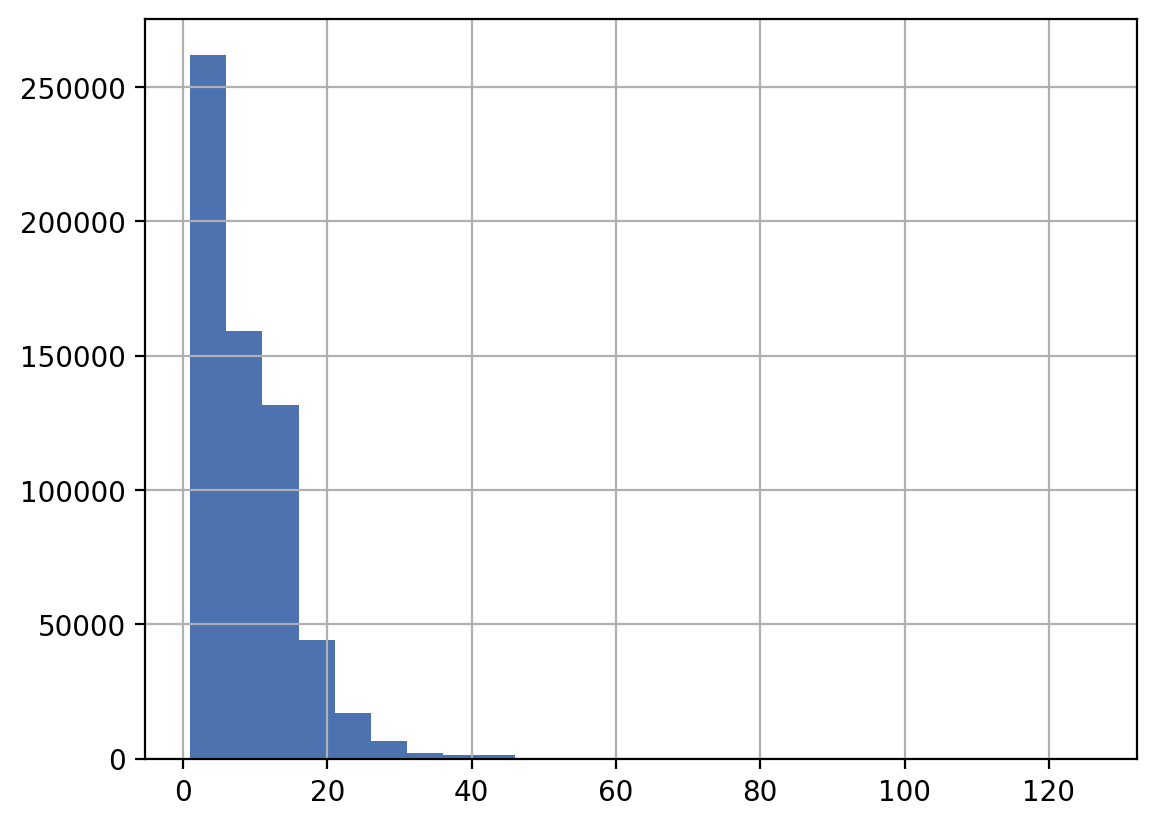

In [28]:
icgc_dist_all_metrics_df.query("mut_event in @icgc_dist_mean_metrics_w_annot_df_subset_vaf['mut_event'].unique() and (measured_site_dist <= 10000 and measured_site_dist>= -10000)")['mut_event'].value_counts().hist(bins=25)

count    2599.000000
mean     1237.904963
std       380.685989
min         0.000000
25%       951.000000
50%      1152.000000
75%      1453.000000
max      3000.000000
Name: cpg_count_10kb, dtype: float64

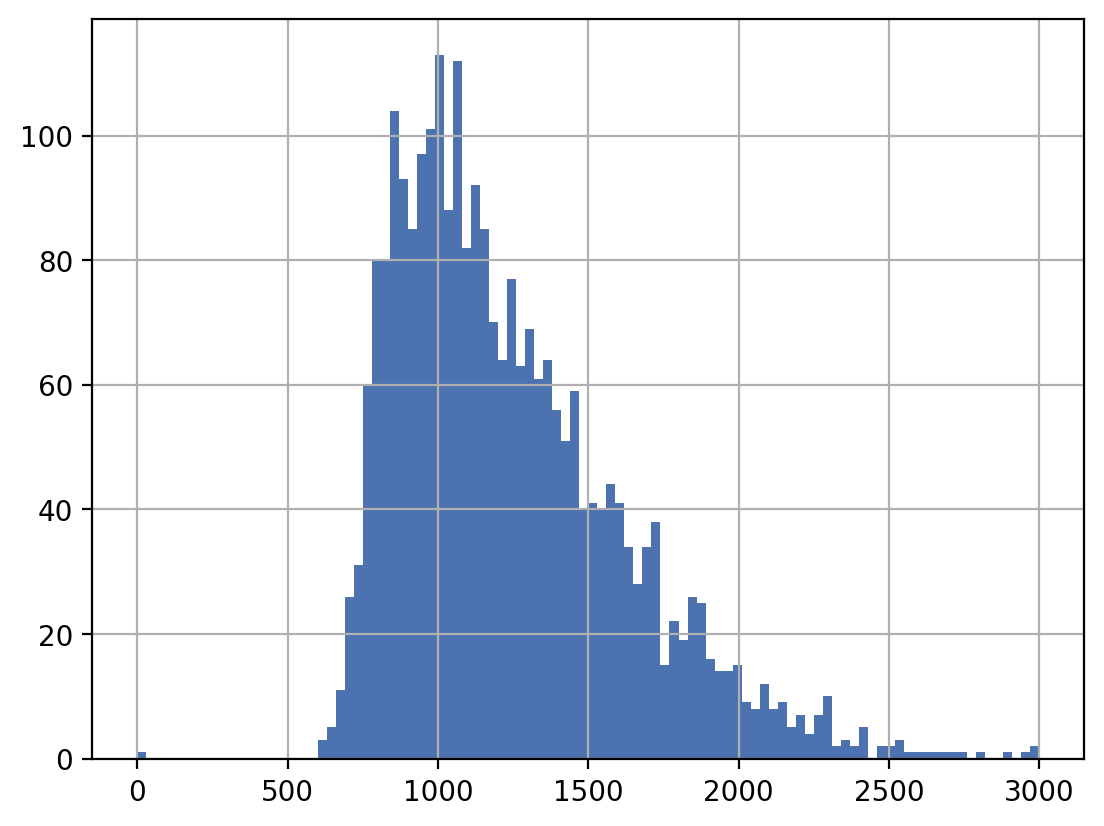

In [56]:
# get average number of CpGs (including non-measured)
icgc_dist_mean_metrics_w_annot_df_subset_vaf.query("is_background == False and mutated_sample == True")['cpg_count_10kb'].hist(bins=100)
icgc_dist_mean_metrics_w_annot_df_subset_vaf.query("is_background == False and mutated_sample == True")['cpg_count_10kb'].describe()

In [53]:
icgc_dist_mean_metrics_w_annot_df_subset_vaf.query("is_background == False and mutated_sample == True")['DNA_VAF'].min()

0.8

In [165]:
icgc_dist_mean_metrics_w_annot_df_subset_vaf.query("is_background == False and mutated_sample == True")['mut_event'].value_counts()

DO229490_5:75012146     1
DO46561_17:14688489     1
DO46493_5:153912273     1
DO46498_11:112918567    1
DO46498_11:133604834    1
                       ..
DO46368_12:129628753    1
DO46368_13:78892429     1
DO46368_18:45661680     1
DO46368_2:136730374     1
DO49105_9:98966494      1
Name: mut_event, Length: 2599, dtype: int64

In [ ]:
icgc_dist_mean_metrics_w_annot_df_subset_vaf

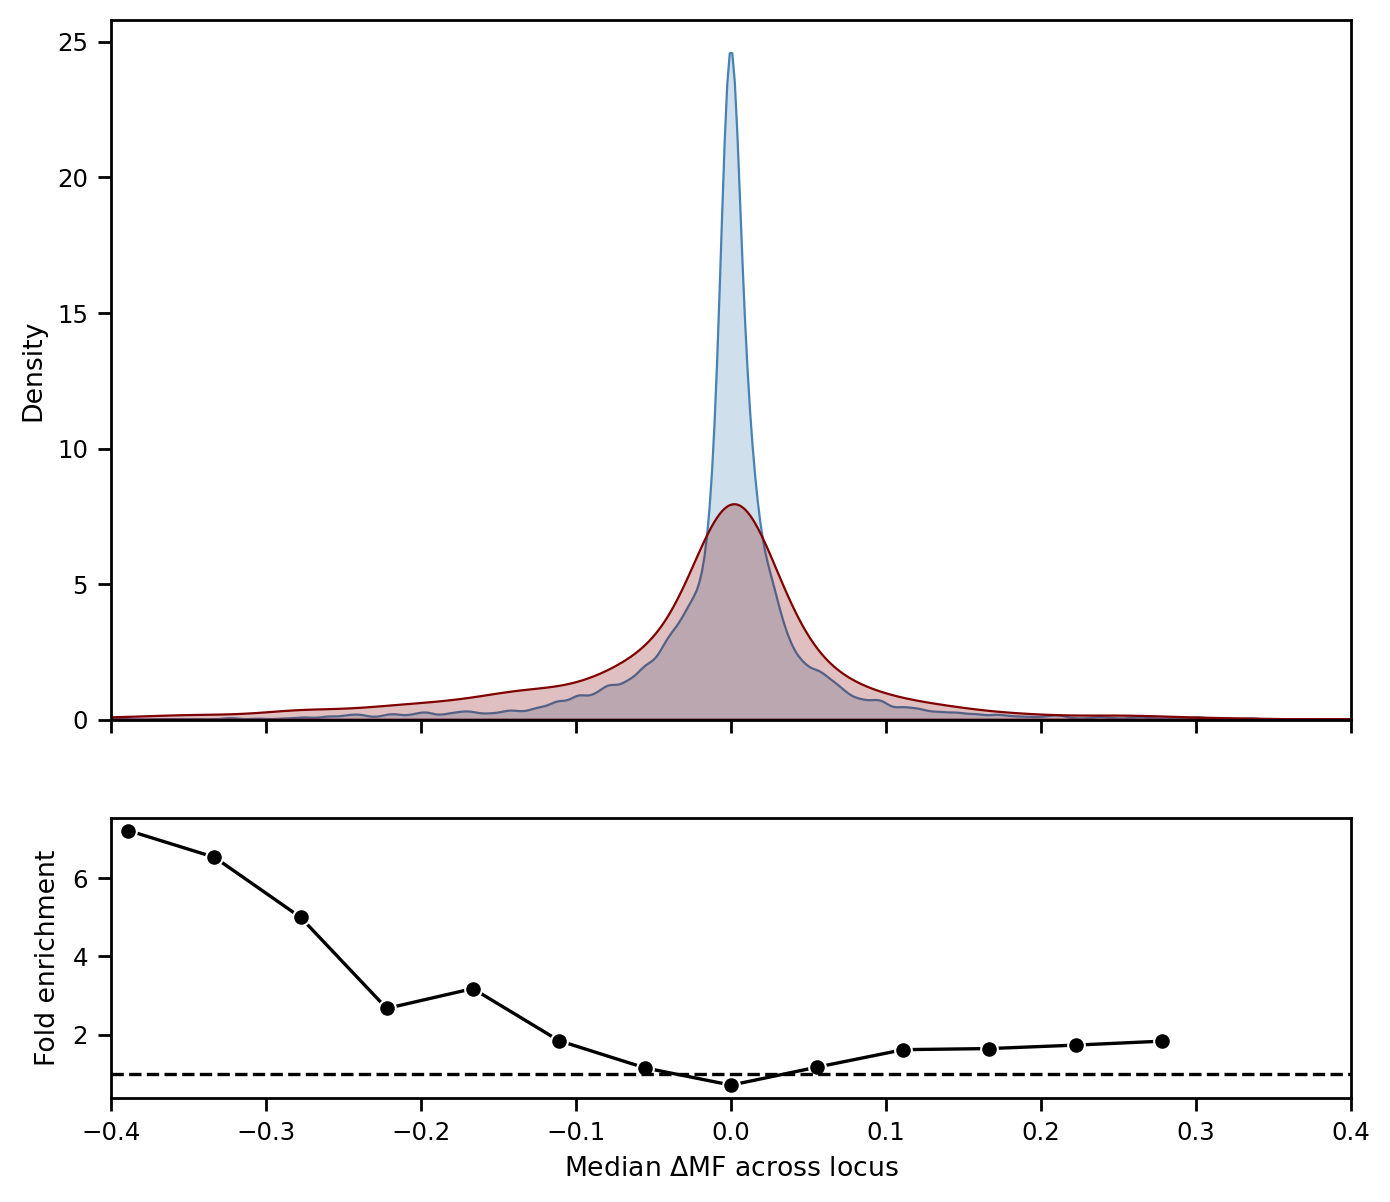

In [170]:
# make second axes bigger kw
fig, axes = plt.subplots(
    2,1, figsize = (8, 7), dpi = 100, gridspec_kw={'height_ratios': [2.5, 1]}, sharex=True
    )
###############################################################
# all
###############################################################
counts = analyze_comethylation.plot_delta_mf_kdeplot(
    icgc_dist_mean_metrics_w_annot_df_subset_vaf,
    metric = 'median_dmf', axes = axes,
    consortium = 'ICGC', out_fn = os.path.join(fig_out_dir, 'figure3', 'figure3a_icgc_median_dmf_kde.svg')
    ) # set minimum ratio value to 5

In [11]:
from scipy.stats import mannwhitneyu
mannwhitneyu(icgc_dist_mean_metrics_w_annot_df.query("is_background == False and mutated_sample == True and distance == 10000")['median_dmf'], icgc_dist_mean_metrics_w_annot_df.query("is_background == True and mutated_sample == True and distance == 10000")['median_dmf'])

MannwhitneyuResult(statistic=1145759716.5, pvalue=2.052912730549376e-08)

In [12]:
mannwhitneyu(icgc_dist_mean_metrics_w_annot_df.query("is_background == False and mutated_sample == True and distance == 10000")['median_abs_dmf'], icgc_dist_mean_metrics_w_annot_df.query("is_background == True and mutated_sample == True and distance == 10000")['median_abs_dmf'])

MannwhitneyuResult(statistic=1413911272.0, pvalue=1.9950673481790353e-74)

In [13]:
mannwhitneyu(icgc_dist_mean_metrics_w_annot_df.query("is_background == False and mutated_sample == True and distance == 10000")['median_dmf'].abs(), icgc_dist_mean_metrics_w_annot_df.query("is_background == True and mutated_sample == True and distance == 10000")['median_dmf'].abs())

MannwhitneyuResult(statistic=1476513942.5, pvalue=1.9656203385644096e-125)

# C) Distance of effect

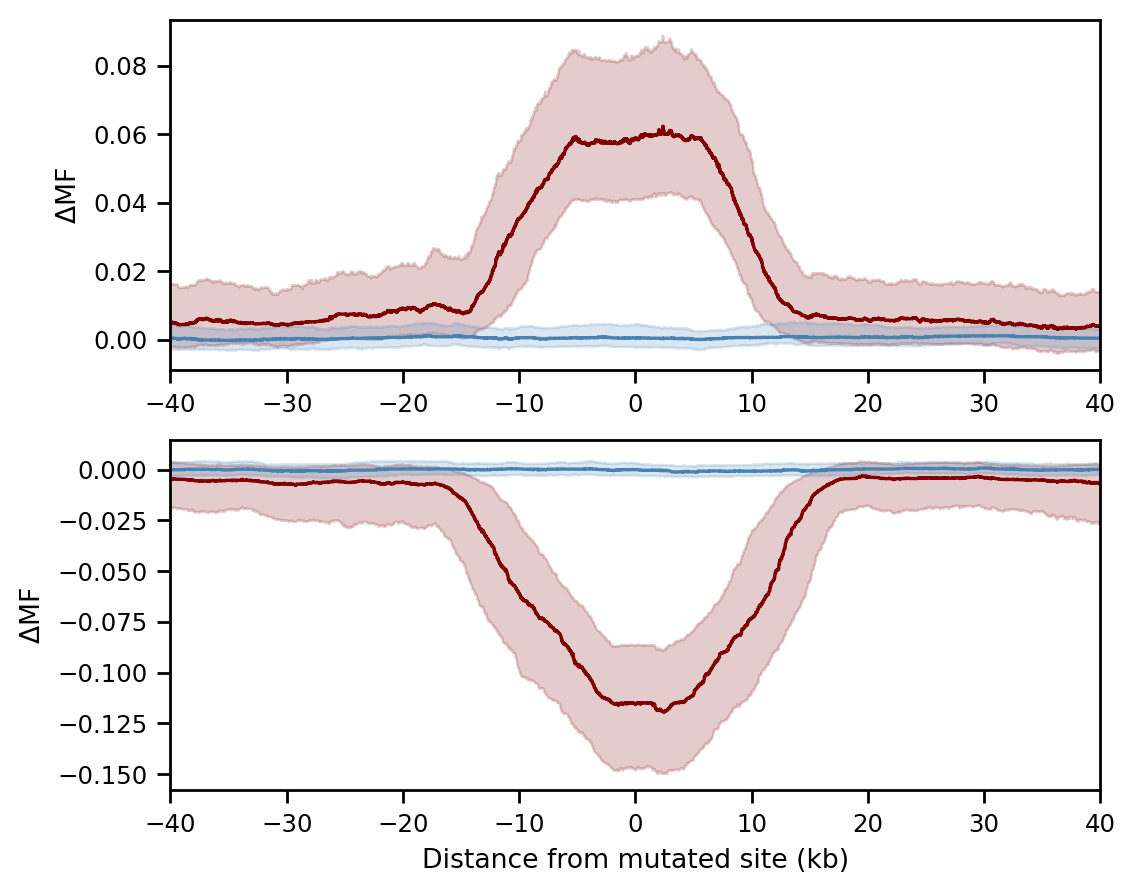

In [27]:
# 
fig, axes = analyze_comethylation.plot_distance_of_effect_lineplot( # smoothing_window_size_dist -2000
    icgc_dist_mean_metrics_df, icgc_dist_all_metrics_df, num_top_muts = 1000, # 25 %
    smoothing_window_size_dist = 2000, smoothing_window_size_corr = 300,
    corr_vs_dist = False, illumina_cpg_locs_df = illumina_cpg_locs_df,
    dist = 10000, plot_bg = True, out_fn = os.path.join(fig_out_dir, 'figure3', 'figure3C_icgc_distance_of_effect_lineplot_rasterized_072523.svg')
    )

In [25]:
fig.savefig(os.path.join(fig_out_dir, 'figure3', 'figure3C_icgc_distance_of_effect_lineplot_new_other.svg'), bbox_inches='tight',  dpi=900)

In [24]:
fig.savefig(os.path.join(fig_out_dir, 'figure3', 'figure3C_icgc_distance_of_effect_lineplot_new_other.png'), bbox_inches='tight',, format = 'png')

# D) enrichment of mutation type

In [14]:
cgi_df = pd.read_csv('/cellar/users/zkoch/methylation_and_mutation/data/genome_annotations/CpG_islands_hg19.bed.gz', sep = '\t', header = None)
cgi_df.columns = ['chr', 'start', 'end', 'name']
cgi_df['length'] = cgi_df['end'] - cgi_df['start']
print("total number of bp in CGI: ", cgi_df['length'].sum())
print("percentage of genome in CGI: ", cgi_df['length'].sum() / 3137144693)
percent_genome_that_is_cgi = cgi_df['length'].sum() / 3137144693

total number of bp in CGI:  23121706
percentage of genome in CGI:  0.00737030269964663


In [15]:
# get background frequency values for CpG outside CGI, CpG inside CGI, non-CpG outside CGI, non-CpG inside CGI

genome_length = 3137144693 # UCSC
percent_genome_that_is_cgi = 0.00737030269964663 # derived from UCSC CGI file
percent_cpgs_in_cgi = 0.07 # youk et al
percent_cpgs_not_in_cgi = 0.93 # youk et al
num_cpgs = 28299634 # UCSC
bp_in_cpg = 28299634 * 2 # UCSC
basepairs_in_cgi = 23121706 # derived from UCSC CGI file
basepairs_not_in_cgi = 3137144693 - 23121706


percent_cgi_that_is_cpg = (bp_in_cpg * percent_cpgs_in_cgi)/(basepairs_in_cgi)# the percent of CG
percent_non_cgi_that_is_cpg = (bp_in_cpg * percent_cpgs_not_in_cgi)/(basepairs_not_in_cgi)

percent_cpg_not_cgi = percent_non_cgi_that_is_cpg * (1 - percent_genome_that_is_cgi)
percent_cpg_and_cgi = percent_cgi_that_is_cpg * percent_genome_that_is_cgi

percent_non_cpg_not_cgi = (1 - percent_non_cgi_that_is_cpg) * (1 - percent_genome_that_is_cgi)
percent_non_cpg_and_cgi = (1 - percent_cgi_that_is_cpg) * percent_genome_that_is_cgi

In [19]:
icgc_dist_mean_metrics_w_annot_df.columns

Index(['mut_event', 'sample', 'mean_dmf', 'mean_abs_dmf', 'median_dmf',
       'median_abs_dmf', 'distance', 'weighted_mean_dmf',
       'log_weighted_mean_dmf', 'is_background', 'index_event',
       'mutated_sample', 'case_submitter_id', 'chr', 'start', 'reference',
       'alt', 'DNA_VAF', 'mutation', 'end', 'mut_type', 'mut_type_combined',
       'seq', 'was_cpg', 'new_seq', 'becomes_cpg', 'is_cgi', 'seq_200bp',
       'gc_perc_200bp'],
      dtype='object')

In [26]:
# choose top and bottom 10% of events
# select only a certain distance of median rows 
filtered_df = icgc_dist_mean_metrics_w_annot_df.query(
    'distance == 10000 & mutated_sample == True & is_background == False'
    )
# drop duplicate mut_events
filtered_df = filtered_df.drop_duplicates(subset=['mut_event'])
# sort them in order of median_dmf
sorted_df = filtered_df.sort_values(by='median_dmf', ascending=False)
# get top and bottom 1000 events, which is about 25%
num_top_muts = 1000 # 25%
neg_indices = sorted_df.index[-num_top_muts:]
pos_indices = sorted_df.index[:num_top_muts]
# create a new df to plot
top_df = sorted_df.loc[pos_indices]
top_df['Methylation change'] = 'Gain'
bottom_df = sorted_df.loc[neg_indices]
bottom_df['Methylation change'] = 'Loss'
y_proportions = {
    "CpG outside CGI": np.array([
        top_df.query("is_cgi == False and was_cpg == True").shape[0] / top_df.shape[0], 
        bottom_df.query("is_cgi == False and was_cpg == True").shape[0] / bottom_df.shape[0]
        ]),
    "CpG in CGI": np.array([
        top_df.query("is_cgi == True and was_cpg == True").shape[0] / top_df.shape[0],
        bottom_df.query("is_cgi == True and was_cpg == True").shape[0] / bottom_df.shape[0]
        ]),
    "non-CpG outside CGI": np.array([
        top_df.query("is_cgi == False and was_cpg == False").shape[0] / top_df.shape[0],
        bottom_df.query("is_cgi == False and was_cpg == False").shape[0] / bottom_df.shape[0]
        ]),
    "non-CpG in CGI": np.array([
        top_df.query("is_cgi == True and was_cpg == False").shape[0] / top_df.shape[0],
        bottom_df.query("is_cgi == True and was_cpg == False").shape[0] / bottom_df.shape[0]
        ]),
}

enrichments = {}
enrichments['CpG outside CGI'] = y_proportions['CpG outside CGI'] / percent_cpg_not_cgi
enrichments['CpG in CGI'] = y_proportions['CpG in CGI'] / percent_cpg_and_cgi
enrichments['non-CpG outside CGI'] = y_proportions['non-CpG outside CGI'] / percent_non_cpg_not_cgi
enrichments['non-CpG in CGI'] = y_proportions['non-CpG in CGI'] / percent_non_cpg_and_cgi
# create df
enrichments_df = pd.DataFrame(enrichments)
# stack
enrichments_df = enrichments_df.stack().reset_index()
# rename
enrichments_df.columns = ['Methylation change direction', 'Functional region', 'Fold-enrichment']
# map Methylation change direction 0 to Gain and 1 to Loss
enrichments_df['Methylation change direction'] = enrichments_df['Methylation change direction'].map({0: 'Gain', 1: 'Loss'})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


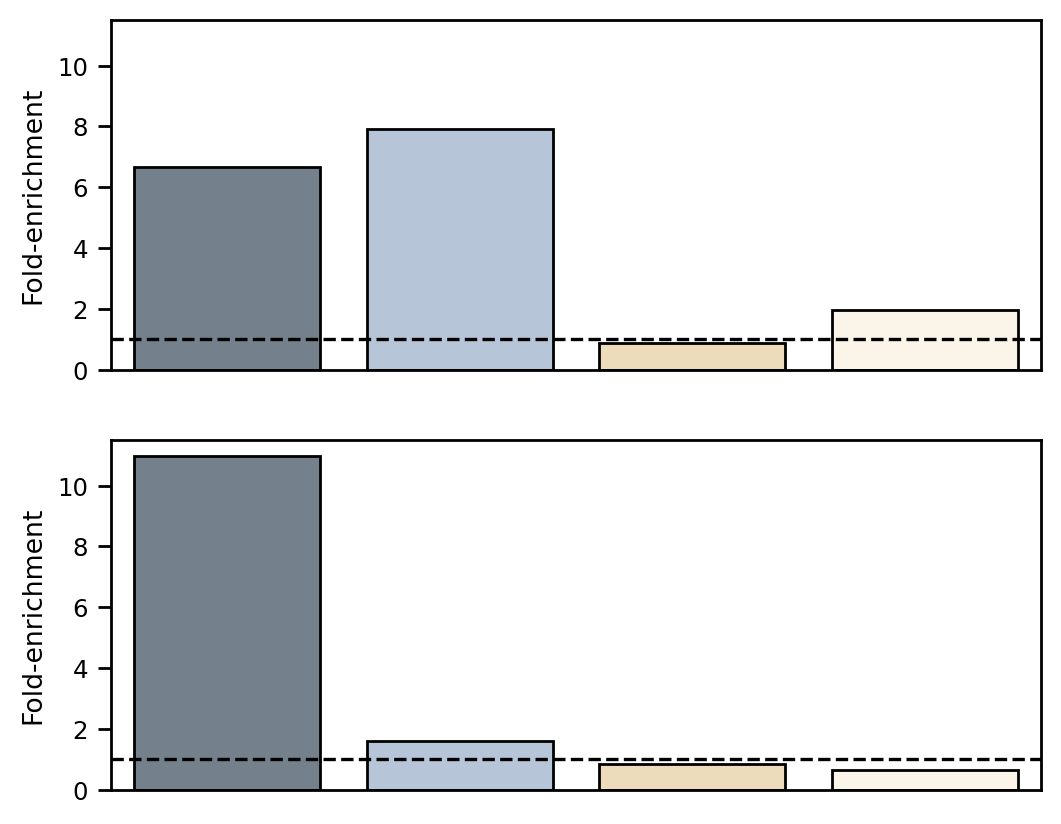

In [152]:
# plot enrichments as barplot
fig, axes = plt.subplots(2, 1, figsize=(6, 5), dpi = 100, sharex='col', sharey='col')
sns.set_context('paper')
sns.barplot(
    data=enrichments_df[enrichments_df['Methylation change direction'] == 'Gain'], y='Fold-enrichment', x='Functional region',
    #hue_order = [ 'CpG in CGI', 'non-CpG in CGI','CpG outside CGI', 'non-CpG outside CGI', ],
    palette=['slategray', 'lightsteelblue', 'wheat', 'oldlace'],
    edgecolor='black', linewidth=1,
    ax=axes[0]
)
axes[0].set_xlabel('')
sns.barplot(
    data=enrichments_df[enrichments_df['Methylation change direction'] == 'Loss'], y='Fold-enrichment', x='Functional region',
    #hue_order = [ 'CpG in CGI', 'non-CpG in CGI','CpG outside CGI', 'non-CpG outside CGI', ],
    palette=['slategray', 'lightsteelblue', 'wheat', 'oldlace'],
    edgecolor='black', linewidth=1,
    ax=axes[1]
)
axes[1].set_xlabel('')
# turn off legend
axes[0].legend().set_visible(False)
# plot dashed line at y = 1
axes[0].axhline(1, ls='--', color='black')
axes[1].axhline(1, ls='--', color='black')
# remove x ticks and labels
axes[0].set_xticklabels([])
axes[1].set_xticks([])
# remove y axes labels
# set super y axis label
plt.savefig(os.path.join(fig_out_dir, 'figure3', 'figure3D_icgc_enrichment.svg'), dpi = 300, format = 'svg')

In [101]:
y_counts = {
    "CpG outside CGI": np.array([
        top_df.query("is_cgi == False and is_cpg == 'CpG'").shape[0] , 
        bottom_df.query("is_cgi == False and is_cpg == 'CpG'").shape[0]
        ]),
    "CpG in CGI": np.array([
        top_df.query("is_cgi == True and is_cpg == 'CpG'").shape[0] ,
        bottom_df.query("is_cgi == True and is_cpg == 'CpG'").shape[0]
        ]),
    "non-CpG outside CGI": np.array([
        top_df.query("is_cgi == False and is_cpg == 'Non-CpG'").shape[0] ,
        bottom_df.query("is_cgi == False and is_cpg == 'Non-CpG'").shape[0]
        ]),
    "non-CpG in CGI": np.array([
        top_df.query("is_cgi == True and is_cpg == 'Non-CpG'").shape[0],
        bottom_df.query("is_cgi == True and is_cpg == 'Non-CpG'").shape[0]
        ]),
}

In [103]:
y_expected = {
    "CpG outside CGI": np.array([
        top_df.shape[0] * percent_cpg_not_cgi, 
        bottom_df.shape[0] * percent_cpg_not_cgi
        ]),
    "CpG in CGI": np.array([
        top_df.shape[0] * percent_cpg_and_cgi,
        bottom_df.shape[0] * percent_cpg_and_cgi
        ]),
    "non-CpG outside CGI": np.array([
        top_df.shape[0] * percent_non_cpg_not_cgi,
        bottom_df.shape[0] * percent_non_cpg_not_cgi
        ]),
    "non-CpG in CGI": np.array([
        top_df.shape[0] * percent_non_cpg_and_cgi,
        bottom_df.shape[0] * percent_non_cpg_and_cgi
        ]),
}

In [114]:
from scipy.stats import binomtest
for key in y_counts.keys():
    print(key)
    print("Enrichments:" ,y_counts[key] / y_expected[key])
    print("Gain:", binomtest(y_counts[key][0], n=1000, p=(y_expected[key][0]/1000), alternative='two-sided'))
    print("Loss:", binomtest(y_counts[key][1], n=1000, p=(y_expected[key][1]/1000), alternative='two-sided'))

CpG outside CGI
Enrichments: [ 6.67511588 10.96626181]
Gain: BinomTestResult(k=112, n=1000, alternative='two-sided', statistic=0.112, pvalue=4.0590093614447294e-55)
Loss: BinomTestResult(k=184, n=1000, alternative='two-sided', statistic=0.184, pvalue=1.7373785332055702e-127)
CpG in CGI
Enrichments: [7.91818593 1.58363719]
Gain: BinomTestResult(k=10, n=1000, alternative='two-sided', statistic=0.01, pvalue=8.76861425909067e-07)
Loss: BinomTestResult(k=2, n=1000, alternative='two-sided', statistic=0.002, pvalue=0.36004292559501344)
non-CpG outside CGI
Enrichments: [0.88743059 0.83004478]
Gain: BinomTestResult(k=866, n=1000, alternative='two-sided', statistic=0.866, pvalue=6.84558965290319e-57)
Loss: BinomTestResult(k=810, n=1000, alternative='two-sided', statistic=0.81, pvalue=7.425968780487845e-107)
non-CpG in CGI
Enrichments: [1.96483368 0.65494456]
Gain: BinomTestResult(k=12, n=1000, alternative='two-sided', statistic=0.012, pvalue=0.024439160627676978)
Loss: BinomTestResult(k=4, n=100

# E: VAF vs DMF

SignificanceResult(statistic=0.1432118216010092, pvalue=2.1559977608467215e-07)
PearsonRResult(statistic=0.13808634755190463, pvalue=5.794448258385716e-07)


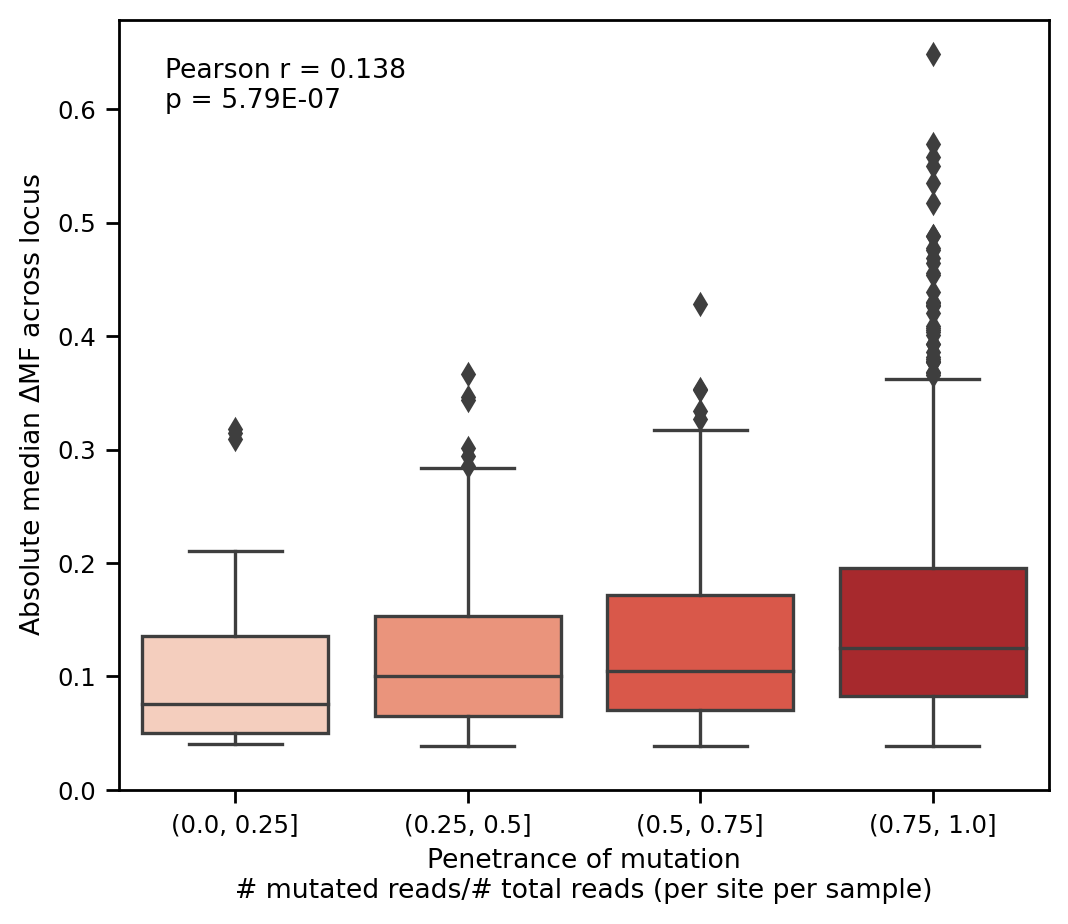

In [44]:
filtered_df = icgc_dist_mean_metrics_w_annot_df.query(
    'distance == 10000 & mutated_sample == True & is_background == False'
    )
# drop duplicate mut_events
filtered_df = filtered_df.drop_duplicates(subset=['mut_event'])
# sort them in order of median_dmf
sorted_df = filtered_df.sort_values(by='median_dmf', ascending=False)
# get top and bottom 650 events, which is  25%
num_top_muts = 650 # 25%
neg_indices = sorted_df.index[-num_top_muts:]
pos_indices = sorted_df.index[:num_top_muts]
top_df = sorted_df.loc[pos_indices]
top_df['Methylation change'] = 'Gain'
bottom_df = sorted_df.loc[neg_indices]
bottom_df['Methylation change'] = 'Loss'
largest_eff_df = pd.concat([top_df, bottom_df])

fig, axes = plt.subplots(figsize = (6,5), dpi = 100)
sns.set_context('paper')

# bin by DNA VAF
largest_eff_df['DNA_VAF_bin'] = pd.cut(
    largest_eff_df['DNA_VAF'],
    bins = pd.IntervalIndex.from_tuples([(0,.25), (.25, .5), (.5, .75), (.75, 1)])
        #[(0, .2), (.2, .4), (.4, .6), (.6, .8), (.8, 1)])
    )
# get absolute value of median dmf
largest_eff_df['abs_median_dmf'] = largest_eff_df['median_dmf'].abs()
# boxplot
sns.boxplot(
    data=largest_eff_df.query("is_background == False"),
    x='DNA_VAF_bin', y='abs_median_dmf', showfliers=True, palette = 'Reds',
    ax = axes
    )
# corrs, median_abs_dmf is better than abs_median_dmf
print(spearmanr(largest_eff_df.query("is_background == False")['DNA_VAF'], largest_eff_df.query("is_background == False")['median_abs_dmf']))
print(pearsonr(largest_eff_df.query("is_background == False")['DNA_VAF'], largest_eff_df.query("is_background == False")['median_abs_dmf']))
# add pearson r and pvalue to upper left corner)
r,p = pearsonr(largest_eff_df.query("is_background == False")['DNA_VAF'], largest_eff_df.query("is_background == False")['median_abs_dmf'])
# add pearson r and pvalue to upper left corner
axes.text(
    0.05, 0.95, f'Pearson r = {round(r,3)}\np = {p:.2E}', horizontalalignment='left',
    verticalalignment='top', transform=axes.transAxes
    )
axes.set_ylabel('Absolute median $\Delta$MF across locus')
axes.set_xlabel('Penetrance of mutation\n# mutated reads/# total reads (per site per sample)')
# include 0 on y axis
axes.set_ylim(bottom=0)
plt.savefig(os.path.join(fig_out_dir, 'figure3', 'figure3E_DNAVAF_vs_absDMF_distance_ICGC.svg'), dpi = 300, format = 'svg')


# Supp fig, CpG vs non-CpG mutations

0.1447763530078306
0.12002925707815715
20.617553196683833


Text(0.05, 0.92, 'Median non-CpG = 0.12\nMedian CpG = 0.145')

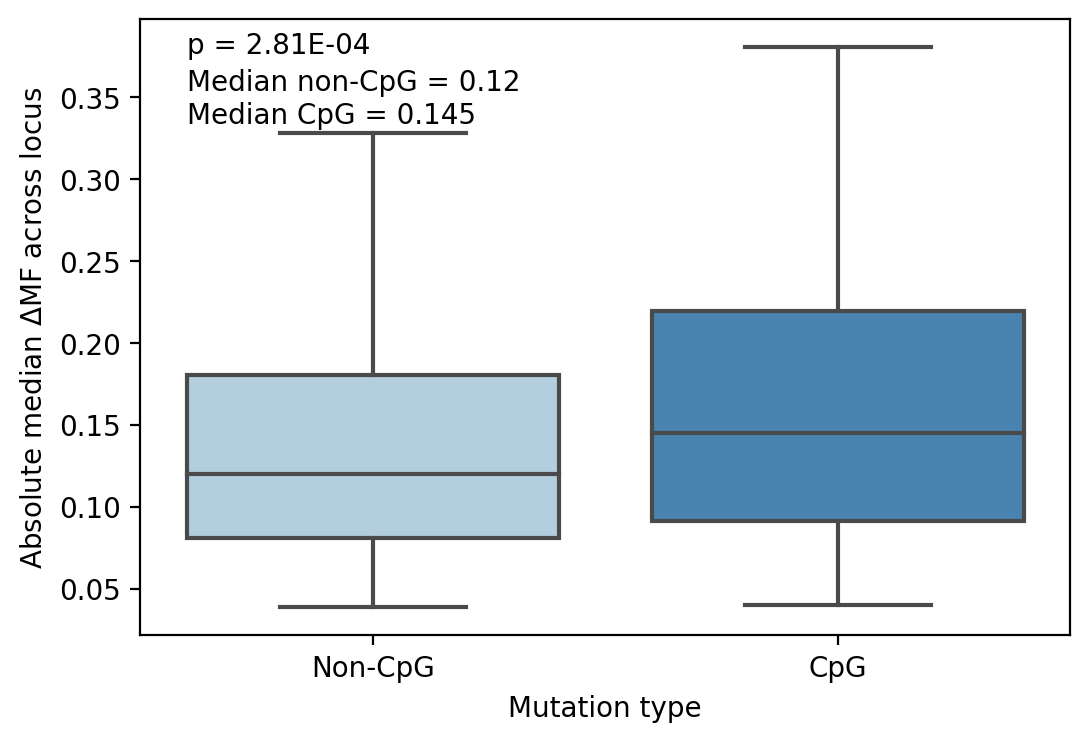

In [10]:
filtered_df = icgc_dist_mean_metrics_w_annot_df.query(
    'distance == 10000 & mutated_sample == True & is_background == False'
    )
# drop duplicate mut_events
filtered_df = filtered_df.drop_duplicates(subset=['mut_event'])
# sort them in order of median_dmf
sorted_df = filtered_df.sort_values(by='median_dmf', ascending=False)
# get top and bottom 650 events, which is  25%
num_top_muts = 650 # 25%
neg_indices = sorted_df.index[-num_top_muts:]
pos_indices = sorted_df.index[:num_top_muts]
top_df = sorted_df.loc[pos_indices]
top_df['Methylation change'] = 'Gain'
bottom_df = sorted_df.loc[neg_indices]
bottom_df['Methylation change'] = 'Loss'
largest_eff_df = pd.concat([top_df, bottom_df])

fig, axes = plt.subplots(figsize = (6,4), dpi = 100)
sns.boxplot(data = largest_eff_df, y = 'median_abs_dmf', x = 'was_cpg', palette='Blues', ax = axes, showfliers=False)
# test for a difference in median absolute dmf between cpg and non-cpg using mann whitney u test
print(np.median(largest_eff_df.query("was_cpg == True")['median_abs_dmf']))
print(np.median(largest_eff_df.query("was_cpg == False")['median_abs_dmf']))
print(100 *(np.median(largest_eff_df.query("was_cpg == True")['median_abs_dmf'])- np.median(largest_eff_df.query("was_cpg == False")['median_abs_dmf'])) / np.median(largest_eff_df.query("was_cpg == False")['median_abs_dmf']))
s, p = mannwhitneyu(largest_eff_df.query("was_cpg == True")['median_abs_dmf'], largest_eff_df.query("was_cpg == False")['median_abs_dmf'])
# set x axis label
axes.set_xlabel('Mutation type')
# set x ticks 
axes.set_xticklabels(['Non-CpG', 'CpG'])
# set y axis label
axes.set_ylabel('Absolute median $\Delta$MF across locus')
# add pvalue and medians to plot
axes.text(
    0.05, 0.98, f'p = {p:.2E}', horizontalalignment='left',
    verticalalignment='top', transform=axes.transAxes
    )
axes.text(
    0.05, 0.92, f'Median non-CpG = {round(np.median(largest_eff_df.query("was_cpg == False")["median_abs_dmf"]),3)}\nMedian CpG = {round(np.median(largest_eff_df.query("was_cpg == True")["median_abs_dmf"]),3)}', horizontalalignment='left',
    verticalalignment='top', transform=axes.transAxes
)
#plt.savefig(os.path.join(fig_out_dir, 'supplemental', 'cpg_vs_non_cpg_DMF_distance.svg'), dpi = 300, format = 'svg')



In [11]:
largest_eff_df

,mut_event,sample,mean_dmf,mean_abs_dmf,median_dmf,median_abs_dmf,distance,weighted_mean_dmf,log_weighted_mean_dmf,is_background,...,mut_type,mut_type_combined,seq,was_cpg,new_seq,becomes_cpg,is_cgi,seq_200bp,gc_perc_200bp,Methylation change
570543,DO33091_15:61818722,DO33091,0.569219,0.569219,0.569219,0.569219,10000,0.569219,0.569219,False,...,G>A,C>T,CGC,True,CAC,False,False,GTCTGCGTTGGAGCAAACATACATCAGCTAATGATGAACTTCCAAA...,0.465,Gain
504006,DO33656_8:22962641,DO33656,0.410878,0.483553,0.550213,0.550213,10000,0.362308,0.408930,False,...,T>A,T>A,CTC,False,CAC,False,False,TGCTGGGCTGGTCCAATCTGTGCGCCAGGTCCTTCCACACCATTCC...,0.575,Gain
571844,DO35571_15:95735722,DO35571,0.454113,0.454113,0.454113,0.454113,10000,0.454113,0.454113,False,...,G>A,C>T,CGG,True,CAG,False,False,CAAGACTGCAGAATTGCATGGGGTCATACTTTTAGACTGACATGAG...,0.405,Gain
503902,DO33656_6:117395601,DO33656,0.429133,0.429133,0.429133,0.429133,10000,0.429133,0.429133,False,...,G>T,C>A,agg,False,aTg,False,False,taaattggtaccagtagagtggggtgctgctgaaaagatacccaaa...,0.445,Gain
249977,DO46329_5:159561030,DO46329,0.428630,0.428630,0.428630,0.428630,10000,0.439207,0.430411,False,...,G>A,C>T,CGT,True,CAT,False,False,ttccgagggacagcagggactagaacAGGCAccccccgcccccgcc...,0.590,Gain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110306,DO46483_13:61659972,DO46483,-0.488004,0.488004,-0.488004,0.488004,10000,-0.488004,-0.488004,False,...,G>A,C>T,gga,False,gAa,False,False,tccaaatacagaaaagaacaagtggggatttttagtcaaggagtag...,0.455,Loss
619869,DO49105_13:94007152,DO49105,-0.517523,0.517523,-0.517523,0.517523,10000,-0.517523,-0.517523,False,...,C>T,C>T,ACC,False,ATC,False,False,CGTGGACAGAGAATCCACCCACTTCAAGTGGGACAAAGAGATCCCA...,0.390,Loss
618258,DO49105_12:128650218,DO49105,-0.534808,0.534808,-0.534808,0.534808,10000,-0.534808,-0.534808,False,...,C>T,C>T,gca,False,gTa,False,False,acaaaggtcaaaattagctgagtcatgctcctttctggaggctctg...,0.460,Loss
443311,DO35627_10:132627334,DO35627,-0.540335,0.540335,-0.557601,0.557601,10000,-0.533565,-0.539547,False,...,G>T,C>A,agg,False,aTg,False,False,gtatatatgtggaaaaccgtaaaaggttgatgaaggaaatcaagat...,0.360,Loss


0.1447763530078306
0.12002925707815715
20.617553196683833


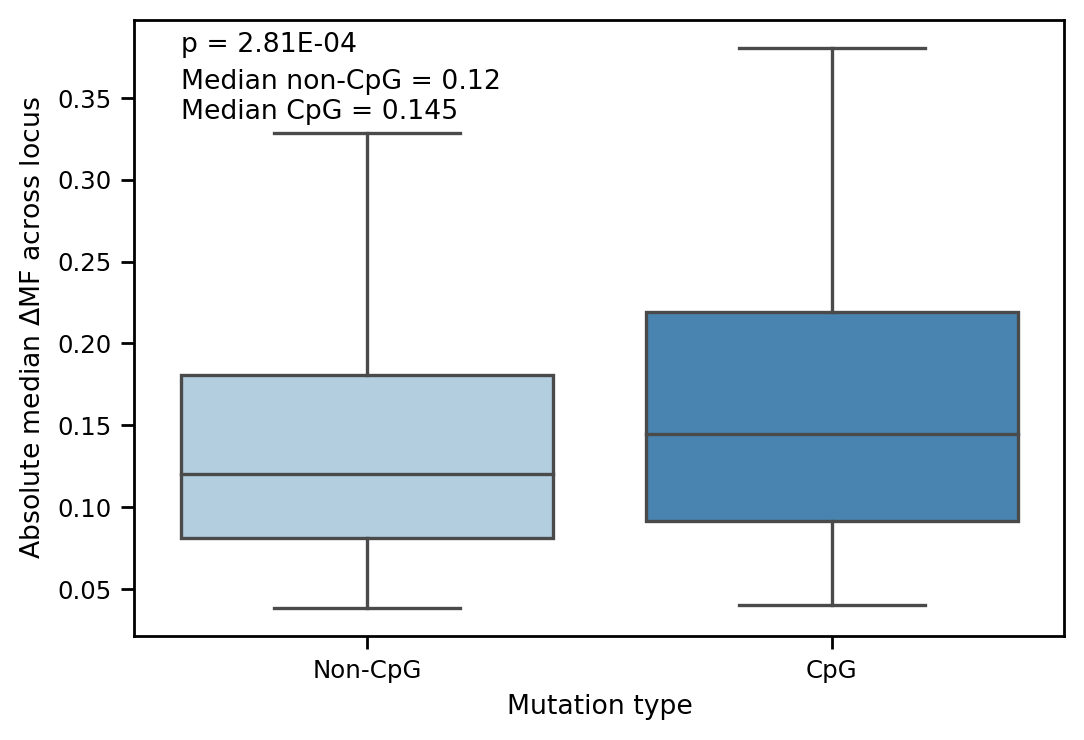

In [55]:
filtered_df = icgc_dist_mean_metrics_w_annot_df.query(
    'distance == 10000 & mutated_sample == True & is_background == False'
    )
# drop duplicate mut_events
filtered_df = filtered_df.drop_duplicates(subset=['mut_event'])
# sort them in order of median_dmf
sorted_df = filtered_df.sort_values(by='median_dmf', ascending=False)
# get top and bottom 650 events, which is  25%
num_top_muts = 650 # 25%
neg_indices = sorted_df.index[-num_top_muts:]
pos_indices = sorted_df.index[:num_top_muts]
top_df = sorted_df.loc[pos_indices]
top_df['Methylation change'] = 'Gain'
bottom_df = sorted_df.loc[neg_indices]
bottom_df['Methylation change'] = 'Loss'
largest_eff_df = pd.concat([top_df, bottom_df])

fig, axes = plt.subplots(figsize = (6,4), dpi = 100)
sns.boxplot(data = largest_eff_df, y = 'median_abs_dmf', x = 'was_cpg', palette='Blues', ax = axes, showfliers=False)
# test for a difference in median absolute dmf between cpg and non-cpg using mann whitney u test
print(np.median(largest_eff_df.query("was_cpg == True")['median_abs_dmf']))
print(np.median(largest_eff_df.query("was_cpg == False")['median_abs_dmf']))
print(100 *(np.median(largest_eff_df.query("was_cpg == True")['median_abs_dmf'])- np.median(largest_eff_df.query("was_cpg == False")['median_abs_dmf'])) / np.median(largest_eff_df.query("was_cpg == False")['median_abs_dmf']))
s, p = mannwhitneyu(largest_eff_df.query("was_cpg == True")['median_abs_dmf'], largest_eff_df.query("was_cpg == False")['median_abs_dmf'])
# set x axis label
axes.set_xlabel('Mutation type')
# set x ticks 
axes.set_xticklabels(['Non-CpG', 'CpG'])
# set y axis label
axes.set_ylabel('Absolute median $\Delta$MF across locus')
# add pvalue and medians to plot
axes.text(
    0.05, 0.98, f'p = {p:.2E}', horizontalalignment='left',
    verticalalignment='top', transform=axes.transAxes
    )
axes.text(
    0.05, 0.92, f'Median non-CpG = {round(np.median(largest_eff_df.query("was_cpg == False")["median_abs_dmf"]),3)}\nMedian CpG = {round(np.median(largest_eff_df.query("was_cpg == True")["median_abs_dmf"]),3)}', horizontalalignment='left',
    verticalalignment='top', transform=axes.transAxes
)
#plt.savefig(os.path.join(fig_out_dir, 'supplemental', 'cpg_vs_non_cpg_DMF_distance.svg'), dpi = 300, format = 'svg')



# Supplemental TCGA Versions of all 

### Test tumor purity vs delta_mf

In [7]:
purity_df = pd.read_excel('/cellar/users/zkoch/methylation_and_mutation/data/tumor_purity/41467_2015_BFncomms9971_MOESM1236_ESM.xlsx', header = 3)

Unknown extension is not supported and will be removed


### KDE plot

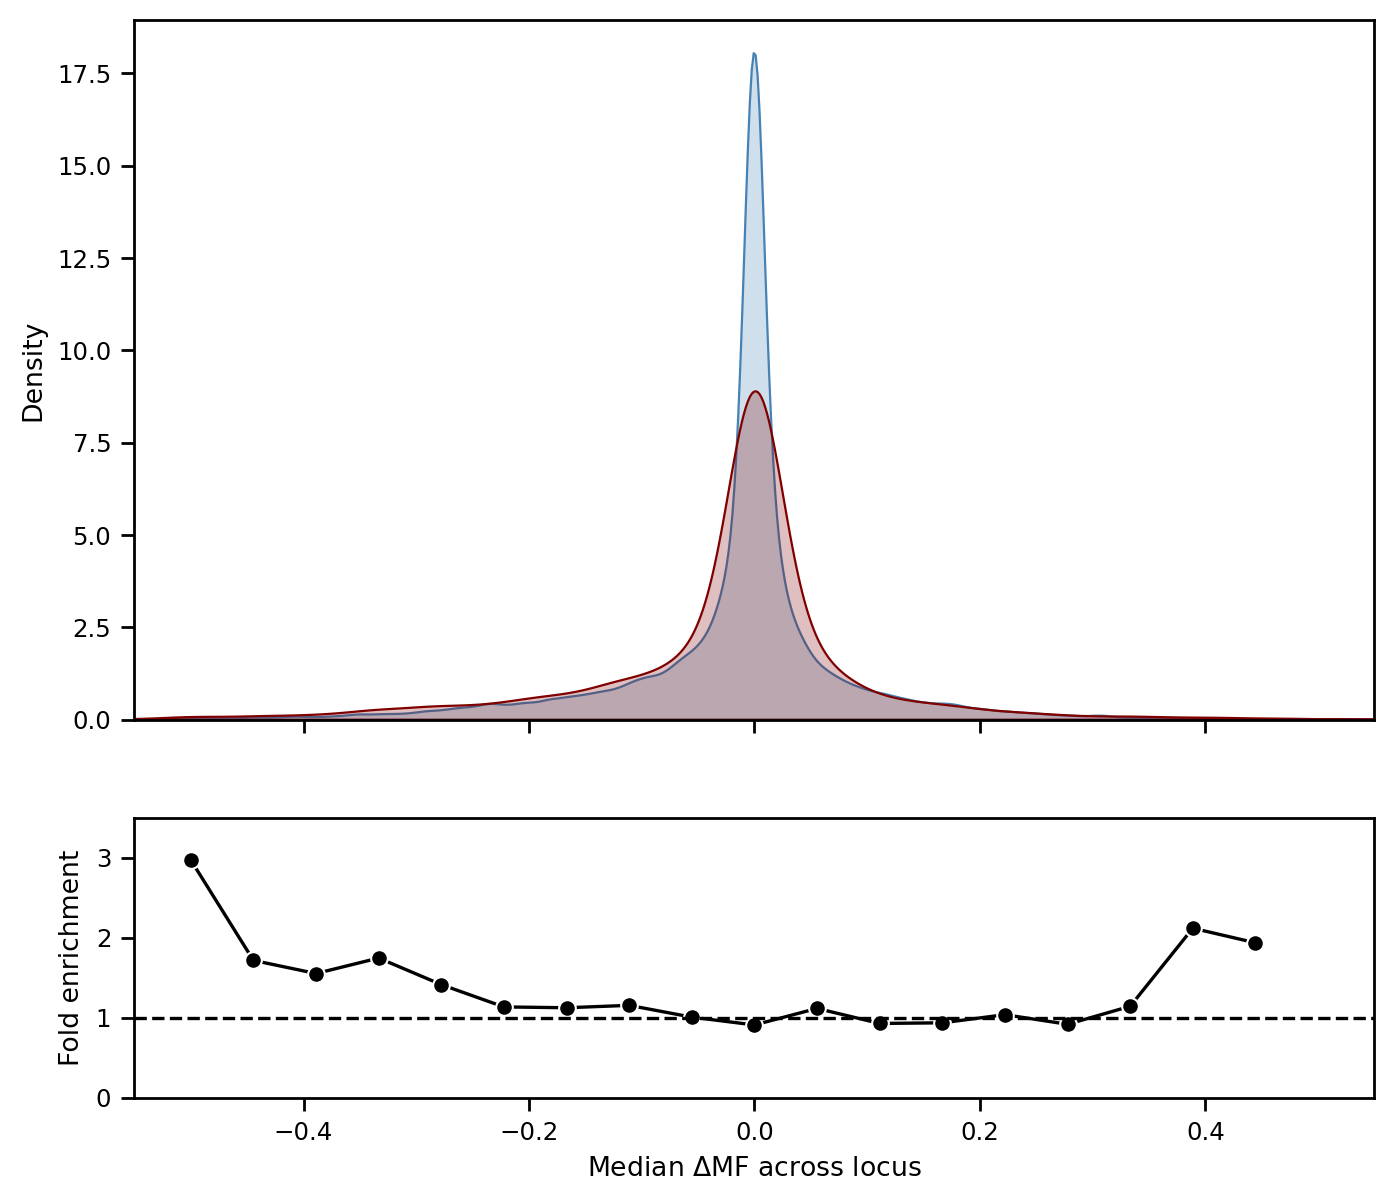

In [28]:
# make second axes bigger kw
fig, axes = plt.subplots(
    2,1, figsize = (8, 7), dpi = 100, gridspec_kw={'height_ratios': [2.5, 1]}, sharex=True
    )
###############################################################
# all
###############################################################
counts = analyze_comethylation.plot_delta_mf_kdeplot(
    tcga_dist_mean_metrics_w_annot_df,
    metric = 'median_dmf', axes = axes,
    consortium = 'TCGA', out_fn = os.path.join('/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures/supplemental', 'supp_tcga_version_of_fig3b_kdeplot.svg')
    ) # set minimum ratio value to 15

### Distance of effect

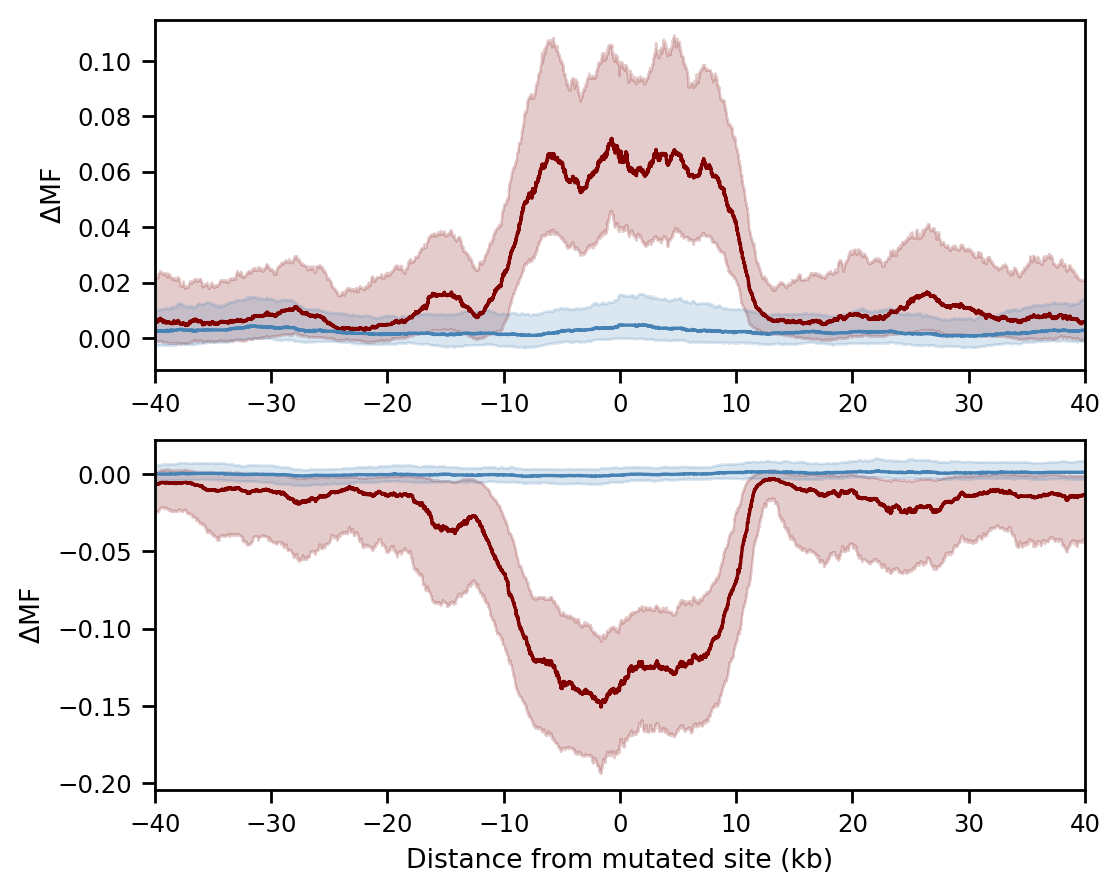

In [35]:
fig, axes = analyze_comethylation.plot_distance_of_effect_lineplot( # smoothing_window_size_dist -2000
    tcga_dist_mean_metrics_w_annot_df, tcga_dist_all_metrics_df, num_top_muts = 1875, # 25%
    smoothing_window_size_dist = 2000, smoothing_window_size_corr = 300,
    corr_vs_dist = False, illumina_cpg_locs_df = illumina_cpg_locs_df,
    dist = 10000, plot_bg = True, out_fn = os.path.join('/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures/supplemental', 'supp_tcga_version_of_fig3C_distance_of_effect.svg')
    )

### Boxplots of functional regions

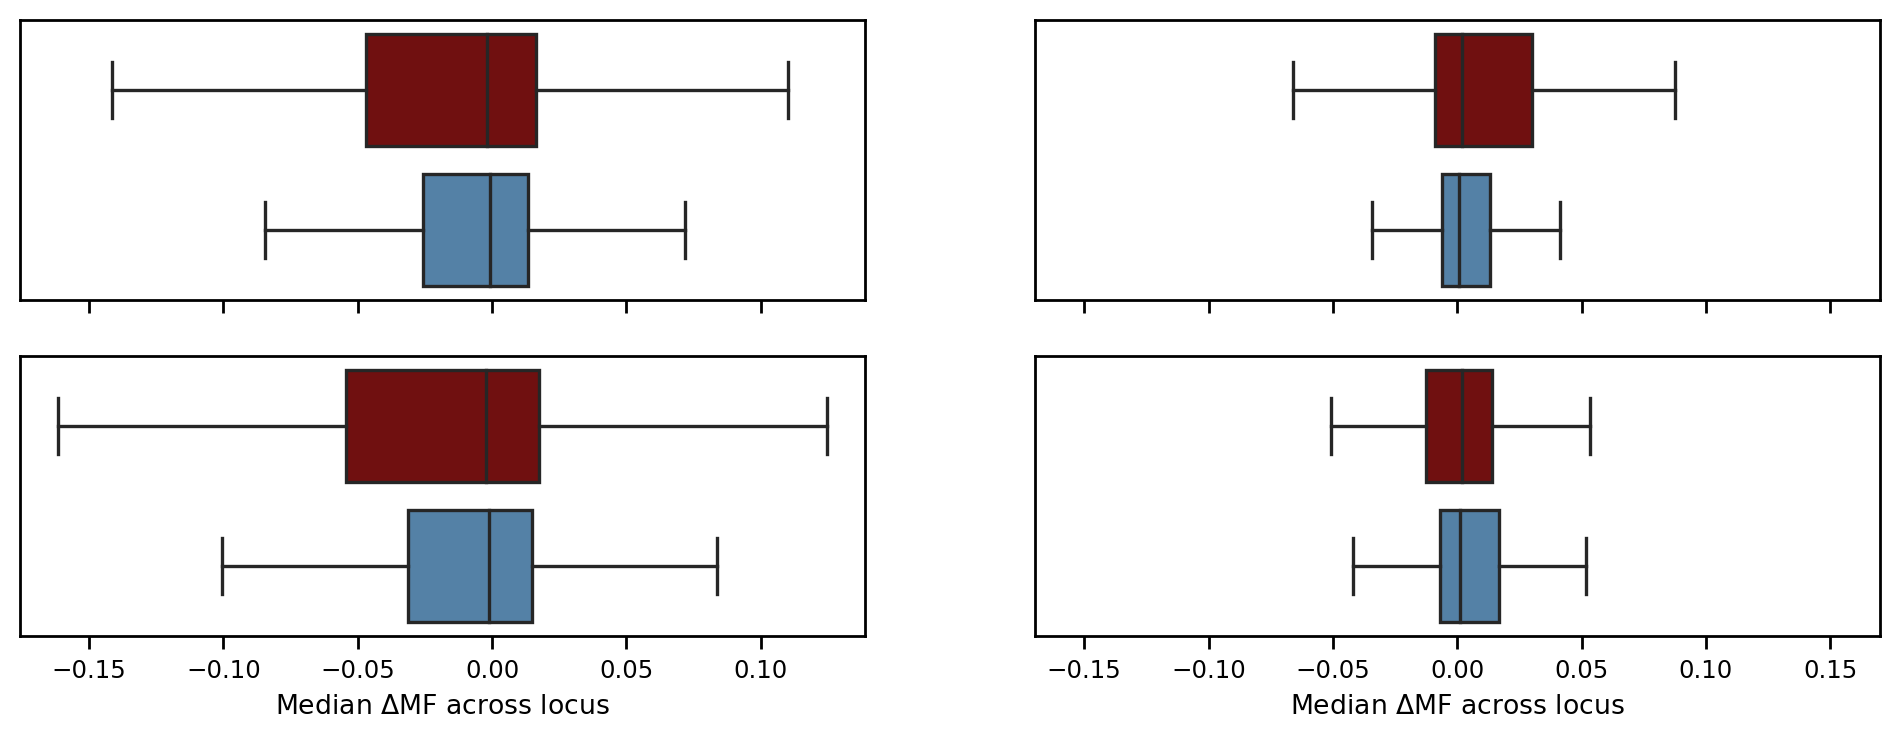

In [29]:
# make second axes bigger kw
fig, axes = plt.subplots(2,2, figsize = (12, 4), dpi = 100, sharex='col')
axes = axes.flatten()
sns.set_context('paper')
###############################################################
# all
###############################################################
# do not show x or y ticks or labels
tcga_dist_mean_metrics_w_annot_df['is_cpg'] = tcga_dist_mean_metrics_w_annot_df['seq'].str.upper().str.contains('CG')
tcga_dist_mean_metrics_w_annot_df['is_cpg'] = tcga_dist_mean_metrics_w_annot_df['is_cpg'].map({True: 'CpG', False: 'Non-CpG'})

tcga_dist_mean_metrics_w_annot_df['is_cgi_renamed'] = tcga_dist_mean_metrics_w_annot_df['is_cgi'].map({True: 'in CGI', False: 'not in CGI'})

tcga_dist_mean_metrics_w_annot_df['combined_category'] = tcga_dist_mean_metrics_w_annot_df['is_cpg'] + '\n' + tcga_dist_mean_metrics_w_annot_df['is_cgi_renamed']

mut = tcga_dist_mean_metrics_w_annot_df.loc[tcga_dist_mean_metrics_w_annot_df.mutated_sample == True]
mut = mut.rename(
    columns={'is_background': 'Locus'}
    ).replace(
                {'Locus': {True: 'Random', False: 'Mutated'}}
                )
  

bins = np.linspace(-.75, .75, 28)
sns.boxplot(
    data=mut.query("is_cgi == False and is_cpg == 'CpG'"), x='median_dmf', y='Locus',
    palette=['maroon', 'steelblue'],
    ax = axes[0], showfliers=False, order = ['Mutated', 'Random'] #, bins=bins, stat='probability',
    #element= 'step', kde = True
    )
sns.boxplot(
    data=mut.query("is_cgi == False and is_cpg == 'Non-CpG'"), x='median_dmf', y='Locus',
    palette=['maroon', 'steelblue'],
    ax = axes[2], showfliers=False,order = ['Mutated', 'Random'] #, bins=bins, stat='probability',
    #element= 'step', kde = True
    )
sns.boxplot(
    data=mut.query("is_cgi == True and is_cpg == 'CpG'"), x='median_dmf', y='Locus',
    palette=['maroon', 'steelblue'],
    ax = axes[1], showfliers=False,order = ['Mutated', 'Random'] #, bins=bins, stat='probability',
    #element= 'step', kde = True
    )

sns.boxplot(
    data=mut.query("is_cgi == True and is_cpg == 'Non-CpG'"), x='median_dmf', y='Locus',
    palette=['maroon', 'steelblue'],
    ax = axes[3], showfliers=False,order = ['Mutated', 'Random'] # bins=bins, stat='probability',
    #element= 'step', kde = True
    )
axes[3].set_xlim(-.17, .17)
for i in range(4):
    axes[i].set_yticklabels([])
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')
    axes[i].set_yticks([])
axes[2].set_xlabel(r'Median $\Delta$MF across locus')
axes[3].set_xlabel(r'Median $\Delta$MF across locus')
plt.savefig(os.path.join('/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures/supplemental', 'supp_tcga_version_of_fig3D_boxplots_by_fxnregion.svg'), dpi = 300, format = 'svg')

# Supp figure 3, ICGC delta mf by functional region

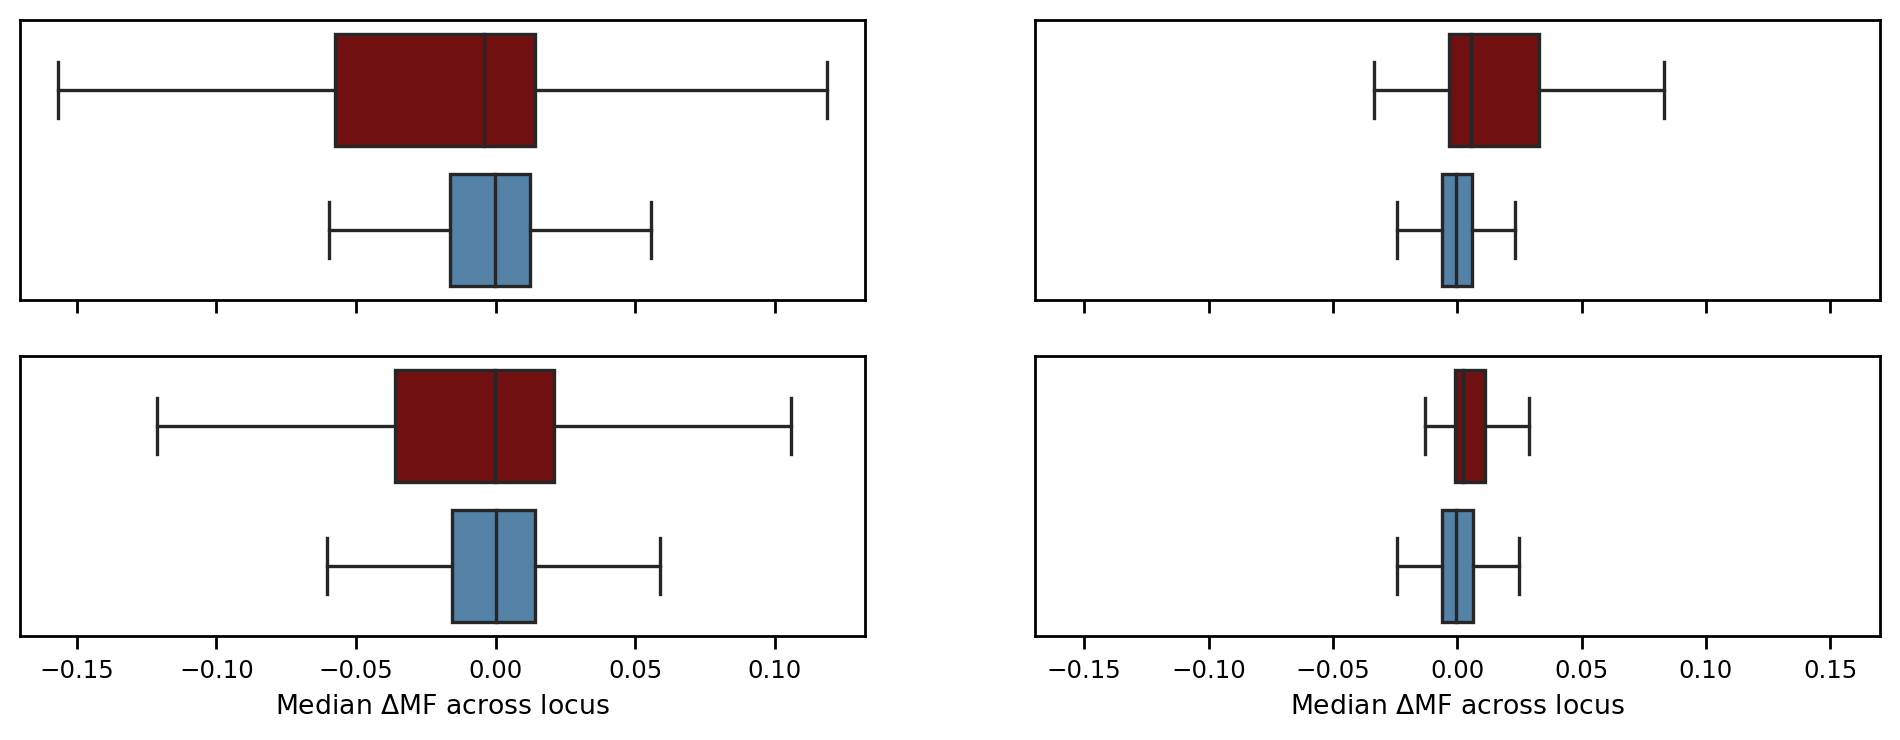

In [154]:
# make second axes bigger kw
fig, axes = plt.subplots(2,2, figsize = (12, 4), dpi = 100, sharex='col')
axes = axes.flatten()
sns.set_context('paper')
###############################################################
# all
###############################################################
# do not show x or y ticks or labels
icgc_dist_mean_metrics_w_annot_df['is_cpg'] = icgc_dist_mean_metrics_w_annot_df['seq'].str.upper().str.contains('CG')
icgc_dist_mean_metrics_w_annot_df['is_cpg'] = icgc_dist_mean_metrics_w_annot_df['is_cpg'].map({True: 'CpG', False: 'Non-CpG'})

icgc_dist_mean_metrics_w_annot_df['is_cgi_renamed'] = icgc_dist_mean_metrics_w_annot_df['is_cgi'].map({True: 'in CGI', False: 'not in CGI'})

icgc_dist_mean_metrics_w_annot_df['combined_category'] = icgc_dist_mean_metrics_w_annot_df['is_cpg'] + '\n' + icgc_dist_mean_metrics_w_annot_df['is_cgi_renamed']

mut = icgc_dist_mean_metrics_w_annot_df.loc[icgc_dist_mean_metrics_w_annot_df.mutated_sample == True]
mut = mut.rename(
    columns={'is_background': 'Locus'}
    ).replace(
                {'Locus': {True: 'Random', False: 'Mutated'}}
                )
  

bins = np.linspace(-.75, .75, 28)
sns.boxplot(
    data=mut.query("is_cgi == False and is_cpg == 'CpG'"), x='median_dmf', y='Locus',
    palette=['maroon', 'steelblue'],
    ax = axes[0], showfliers=False, order = ['Mutated', 'Random'] #, bins=bins, stat='probability',
    #element= 'step', kde = True
    )
sns.boxplot(
    data=mut.query("is_cgi == False and is_cpg == 'Non-CpG'"), x='median_dmf', y='Locus',
    palette=['maroon', 'steelblue'],
    ax = axes[2], showfliers=False,order = ['Mutated', 'Random'] #, bins=bins, stat='probability',
    #element= 'step', kde = True
    )
sns.boxplot(
    data=mut.query("is_cgi == True and is_cpg == 'CpG'"), x='median_dmf', y='Locus',
    palette=['maroon', 'steelblue'],
    ax = axes[1], showfliers=False,order = ['Mutated', 'Random'] #, bins=bins, stat='probability',
    #element= 'step', kde = True
    )

sns.boxplot(
    data=mut.query("is_cgi == True and is_cpg == 'Non-CpG'"), x='median_dmf', y='Locus',
    palette=['maroon', 'steelblue'],
    ax = axes[3], showfliers=False,order = ['Mutated', 'Random'] # bins=bins, stat='probability',
    #element= 'step', kde = True
    )
axes[3].set_xlim(-.17, .17)
for i in range(4):
    axes[i].set_yticklabels([])
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')
    axes[i].set_yticks([])
axes[2].set_xlabel(r'Median $\Delta$MF across locus')
axes[3].set_xlabel(r'Median $\Delta$MF across locus')
plt.savefig(os.path.join(fig_out_dir, 'supplemental', 'icgc_figure3D_icgc_median_dmf_boxplot.svg'), dpi = 300, format = 'svg')

# Supp: GC content vs median dmf

In [37]:
icgc_dist_mean_metrics_w_annot_df['abs_median_dmf'] = icgc_dist_mean_metrics_w_annot_df['median_dmf'].abs()


In [59]:
icgc_dist_mean_metrics_w_annot_df['seq_100bp'] = icgc_dist_mean_metrics_w_annot_df['seq_200bp'].str.upper().str[50:150]

# get the percentage of the sequence that is C, c, g, or G from the middle 50bp of seq_200bp
icgc_dist_mean_metrics_w_annot_df['cpg_perc_200bp'] = (
            icgc_dist_mean_metrics_w_annot_df['seq_200bp'].str.upper().str.count('GC') \
            + icgc_dist_mean_metrics_w_annot_df['seq_200bp'].str.upper().str.count('CG')
            ) / 200

In [60]:
icgc_dist_mean_metrics_w_annot_df.query("is_background == False and mutated_sample == True and distance == 10000").corr()

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


,mean_dmf,mean_abs_dmf,median_dmf,median_abs_dmf,distance,weighted_mean_dmf,log_weighted_mean_dmf,is_background,mutated_sample,start,DNA_VAF,end,was_cpg,becomes_cpg,is_cgi,gc_perc_200bp,abs_median_dmf,gc_perc_50bp,cpg_perc_200bp,cpg_perc_100bp
mean_dmf,1.000000,-0.370786,0.979079,-0.383298,NaN,0.964824,0.998946,NaN,NaN,-0.013211,-0.075061,-0.013211,-0.036386,0.008788,0.045199,0.052527,-0.398839,0.044629,0.065162,0.055805
mean_abs_dmf,-0.370786,1.000000,-0.376186,0.973826,NaN,-0.358394,-0.368621,NaN,NaN,-0.002401,0.121557,-0.002401,0.088625,-0.028516,-0.008542,-0.019223,0.934400,-0.018198,-0.040424,-0.029827
median_dmf,0.979079,-0.376186,1.000000,-0.387588,NaN,0.940776,0.977562,NaN,NaN,-0.016676,-0.075792,-0.016676,-0.027869,0.005221,0.041383,0.050623,-0.403671,0.041919,0.060543,0.050528
median_abs_dmf,-0.383298,0.973826,-0.387588,1.000000,NaN,-0.373468,-0.381891,NaN,NaN,0.004710,0.113920,0.004710,0.072578,-0.026307,-0.037956,-0.056884,0.967053,-0.051954,-0.078767,-0.064950
distance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weighted_mean_dmf,0.964824,-0.358394,0.940776,-0.373468,NaN,1.000000,0.975139,NaN,NaN,-0.018150,-0.075993,-0.018150,-0.035516,0.006322,0.076909,0.057039,-0.386062,0.046784,0.072389,0.059797
log_weighted_mean_dmf,0.998946,-0.368621,0.977562,-0.381891,NaN,0.975139,1.000000,NaN,NaN,-0.015033,-0.074622,-0.015033,-0.035371,0.008540,0.049874,0.053192,-0.397301,0.045072,0.065588,0.056220
is_background,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mutated_sample,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start,-0.013211,-0.002401,-0.016676,0.004710,NaN,-0.018150,-0.015033,NaN,NaN,1.000000,0.004955,1.000000,-0.054451,0.013588,-0.027242,-0.074937,0.013506,-0.068680,-0.071860,-0.058712


<Axes: xlabel='cpg_perc_200bp', ylabel='median_dmf'>

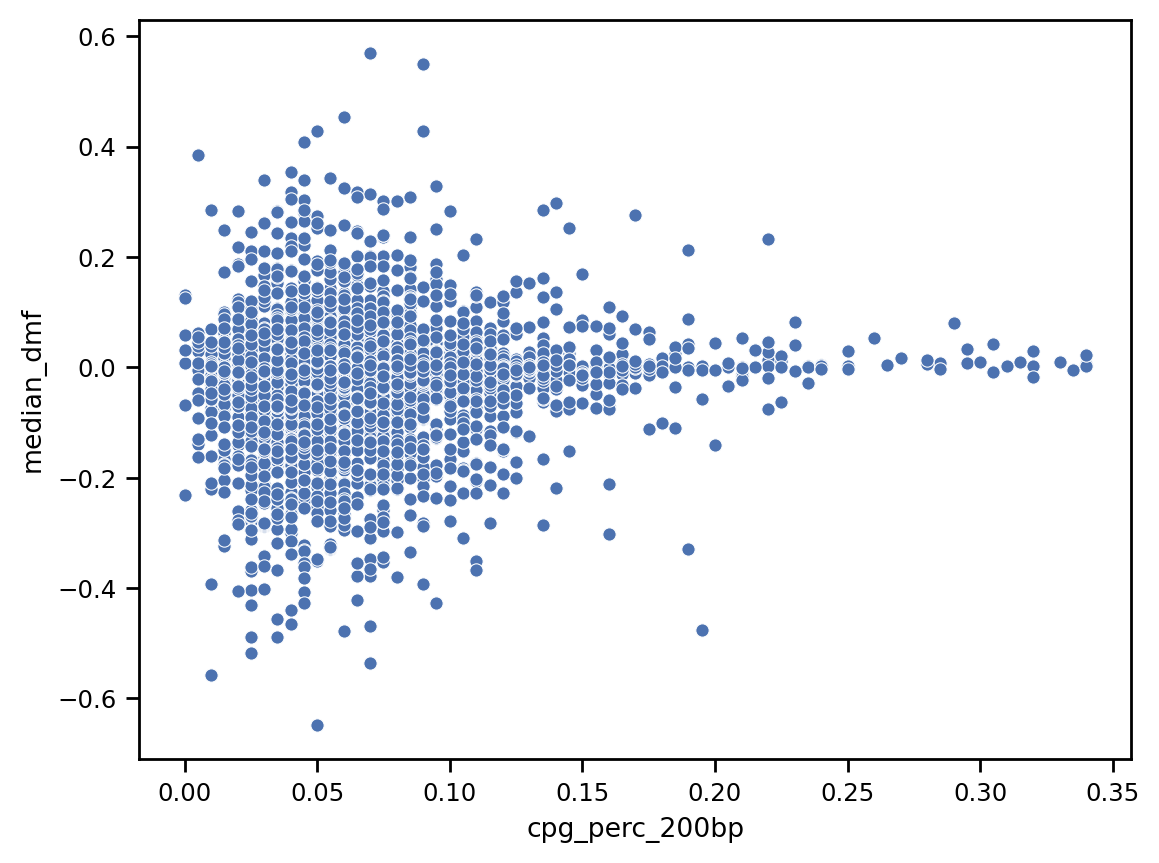

In [62]:
sns.scatterplot(
    data = icgc_dist_mean_metrics_w_annot_df.query("is_background == False and mutated_sample == True and distance == 10000"),
    x = 'cpg_perc_200bp', y = 'median_dmf',
    )